# Wavelet CNN

## Imports

In [1]:
import os
import optuna
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
from torchviz import make_dot
import h5py
import gc


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

c:\Users\Philip Shahdadfar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


DEVICE = 0

Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 0
Cached GPU memory: 0


## Settings

In [3]:
DATASET = 'SLC'    

if DATASET == 'Sal':
    N_PCA = 170
    TRAIN_SIZE = 0.2990 
    EPOCH = 82    
    BATCH_SIZE = 32
    PATCH_SIZE = 13 
    LR = 0.000269    
    WEIGHT_DECAY = 0.0001616  

elif DATASET == 'SalA':
    N_PCA = 150
    TRAIN_SIZE = 0.2721    
    EPOCH = 55    
    BATCH_SIZE = 32
    PATCH_SIZE = 31 
    LR = 0.006597    
    WEIGHT_DECAY = 1e-6 

elif DATASET == 'Indian Pines':
    N_PCA = 190
    TRAIN_SIZE = 0.2755    
    EPOCH = 30    
    BATCH_SIZE = 32
    PATCH_SIZE = 19 
    LR = 0.00726738    
    WEIGHT_DECAY = 0.000640487  
    
elif DATASET == 'PaviaU':
    N_PCA = 103
    TRAIN_SIZE = 0.2892    
    EPOCH = 77    
    BATCH_SIZE = 64
    PATCH_SIZE = 9 
    LR = 0.0005042    
    WEIGHT_DECAY = 0.0001894

elif DATASET == 'SLC':
    N_PCA = 120
    TRAIN_SIZE = 0.3
    BATCH_SIZE = 128
    EPOCH = 50
    PATCH_SIZE = 128 
    LR = 0.001   
    WEIGHT_DECAY = 1e-6 
    
else:
    N_PCA = 190
    
ALL_BANDS = False
VAL_EPOCH = 5
VAL_RATE = 0.1    
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 

Number of bands utilized: 120
Training size: 0.3
Epochs: 50
Batch size: 128
Patch size: 128
Learning rate: 0.001
Weight decay: 1e-06


In [4]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Dataset

In [5]:
# def load_dataset(dataset_name):
 
#     datapath = os.path.join(os.getcwd(), 'Datasets')
    
#     if dataset_name == 'SLC':
#         dataset_path = os.path.join(datapath, 'SLC_R')
#         data_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('radiance.npy')])
#         label_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('FORMAT.npy')])

#         if len(data_files) != len(label_files):
#             raise ValueError("Mismatch between number of data files and label files!")
        

#         # Pre-allocate arrays based on first file dimensions
#         sample_data = np.load(os.path.join(dataset_path, data_files[0]))
#         data = np.empty((len(data_files), *sample_data.shape), dtype=np.float32)
#         labels = np.empty((len(data_files), *sample_data.shape[:2]), dtype=np.int32)

#         # Load files with progress bar
#         for i in tqdm(range(len(data_files)), desc="Loading dataset"):
#             data_path = os.path.join(dataset_path, data_files[i])
#             label_path = os.path.join(dataset_path, label_files[i])
#             data[i] = np.load(data_path)
#             labels[i] = np.load(label_path) + 1

        
#         class_name = ["Sea", "Land", "Cloud"]
#         print(f"Data shape: {data[0].shape}")
#         print(f"Labels shape: {labels[0].shape}")
#         all_labels = np.unique(labels)
#         #all_labels = np.unique(np.concatenate([np.unique(np.load(os.path.join(dataset_path, f))) for f in label_files]))
#         print("All unique labels across dataset:", all_labels)
#         return data, labels, class_name
    
    

#     raise ValueError(f"Dataset {dataset_name} not supported.")

# data, labels, class_name = load_dataset('SLC')

# NUM_CLASS = len(np.unique(labels))
# print(f"Number of classes: {NUM_CLASS}")
# print("Unique labels:", np.unique(labels))


In [6]:


def load_dataset(dataset_name):
    """
    Loads dataset from HDF5 file. If the file does not exist, converts .npy files to .h5 before loading.
    """
    datapath = os.path.join(os.getcwd(), 'Datasets')

    if dataset_name == 'SLC':
        dataset_path = os.path.join(datapath, 'SLC_R')
        hdf5_file = os.path.join(dataset_path, "dataset.h5")

        # If HDF5 file does not exist, create it from .npy files
        if not os.path.exists(hdf5_file):
            print("❌ HDF5 file not found. Converting .npy files to HDF5 format...")
            convert_npy_to_hdf5(dataset_path, hdf5_file)

        # Load the dataset from HDF5
        with h5py.File(hdf5_file, 'r') as hf:
            num_samples = len([key for key in hf.keys() if key.startswith("data_")])  # Ensure correct count

            if num_samples != 37:  # ✅ Ensure all 37 images were loaded
                print(f"❌ WARNING: Expected 37 images, but found {num_samples} in dataset!")

            # Pre-allocate arrays
            data_shape = hf["data_0"].shape
            labels_shape = hf["labels_0"].shape
            data = np.empty((num_samples, *data_shape), dtype=np.float32)
            labels = np.empty((num_samples, *labels_shape), dtype=np.int32)

            # Load data into memory
            for i in tqdm(range(num_samples), desc="Loading dataset"):
                data[i] = hf[f"data_{i}"][:]
                labels[i] = hf[f"labels_{i}"][:]

        class_name = ["Sea", "Land", "Cloud"]
        print(f"✅ Data shape: {data.shape} (Expected: (37, {data_shape[0]}, {data_shape[1]}, {data_shape[2]}))")
        print(f"✅ Labels shape: {labels.shape} (Expected: (37, {labels_shape[0]}, {labels_shape[1]}))")
        print("✅ All unique labels across dataset:", np.unique(labels))

        return data, labels, class_name

    raise ValueError(f"Dataset {dataset_name} not supported.")

def convert_npy_to_hdf5(dataset_path, hdf5_file):
    """
    Converts .npy files to an HDF5 dataset for efficient loading.
    """
    data_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('radiance.npy')])
    label_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('FORMAT.npy')])

    if len(data_files) != 37 or len(label_files) != 37:  # ✅ Ensure all 37 images exist
        print(f"❌ WARNING: Expected 37 images, but found {len(data_files)} data files and {len(label_files)} label files!")

    if len(data_files) != len(label_files):
        raise ValueError("❌ Mismatch between number of data files and label files!")

    with h5py.File(hdf5_file, 'w') as hf:
        for i, (d_file, l_file) in tqdm(enumerate(zip(data_files, label_files)), total=len(data_files), desc="Converting to HDF5"):
            data = np.load(os.path.join(dataset_path, d_file))
            labels = np.load(os.path.join(dataset_path, l_file)) + 1  # Shift labels from {0,1,2} to {1,2,3}
            hf.create_dataset(f"data_{i}", data=data, compression="gzip")
            hf.create_dataset(f"labels_{i}", data=labels, compression="gzip")

    print(f"✅ HDF5 dataset saved at {hdf5_file}")

# Run the dataset loading
data, labels, class_name = load_dataset('SLC')

NUM_CLASS = len(np.unique(labels))
print(f"✅ Number of classes: {NUM_CLASS}")


Loading dataset: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it]


✅ Data shape: (37, 956, 684, 120) (Expected: (37, 956, 684, 120))
✅ Labels shape: (37, 956, 684) (Expected: (37, 956, 684))
✅ All unique labels across dataset: [1 2 3]
✅ Number of classes: 3


## Pre-process data

### Dimensionality Reduction (PCA)

In [7]:
def applyPCA(X, numComponents):
   
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca



### Create image patches (zero-padding)

In [8]:
class PatchSet(Dataset):
    def __init__(self, data, gt, patch_size, stride=None, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            stride: int, step size for extracting patches (Default: patch_size // 2)
            is_pred: bool, create data without labels for prediction (default False)
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        self.stride = stride if stride else patch_size // 2  # Default: 50% overlap
        p = self.patch_size // 2

        # ✅ Pad image and labels
        self.data = np.pad(data, ((p, p), (p, p), (0, 0)), 'constant', constant_values=0)
        self.label = np.pad(gt, ((p, p)), 'constant', constant_values=0)

        if is_pred:
            gt = np.ones_like(gt)

        # ✅ Extract patch positions **only every `stride` pixels**
        self.indices = [
            (x, y)
            for x in range(p, gt.shape[0] + p, self.stride)
            for y in range(p, gt.shape[1] + p, self.stride)
            if gt[x - p, y - p] > 0  # ✅ Only extract patches where labels exist
        ]

        print(f"✅ {len(self.indices)} patches extracted for an image")

        if not is_pred:
            np.random.shuffle(self.indices)  # ✅ Shuffle patches

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        return data if self.is_pred else (data, label)


## Print 

### Display HSI

In [9]:
# for i in range(len(data)):
#     print(f"\nDisplaying Image {i+1}/{len(data)}")

#     # Create a figure with 3 subplots in a single row
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#     # RGB Composite View using Matplotlib (Extracted from Spectral Library)
#     rgb = spectral.get_rgb(data[i], (29, 20, 10))  # Extract RGB image
#     axes[0].imshow(rgb)
#     axes[0].set_title(f'RGB origin {i+1}')
#     axes[0].axis('off')

#     # Ground Truth View
#     axes[1].imshow(labels[i], cmap='jet')
#     axes[1].set_title(f'GroundTruth {i+1}')
#     axes[1].axis('off')

#     # Overlay View
#     axes[2].imshow(data[i][:, :, 0], cmap='gray')  # Show first spectral band as grayscale
#     axes[2].imshow(labels[i], cmap='jet', alpha=0.5)  # Overlay labels
#     axes[2].set_title(f'Overlay {i+1}')
#     axes[2].axis('off')

#     # Display the full row before moving to the next image
#     plt.show()

In [10]:
pbar = tqdm(range(len(data)), desc="Applying PCA")
for i in pbar:
    data[i], pca = applyPCA(data[i], N_PCA)
    pbar.set_description(f"Processing Image {i+1}/37")

Processing Image 37/37: 100%|██████████| 37/37 [02:17<00:00,  3.71s/it]


In [11]:
def sample_gt_per_image(labels, train_rate=TRAIN_SIZE):
    """
    Splits entire images into training or testing groups.
    """
    num_images = len(labels)  # Total number of images (should be 37)
    
    # Generate indices for all images
    image_indices = np.arange(num_images)

    # Split image indices into training (30%) and testing (70%)
    train_indices, test_indices = train_test_split(
        image_indices, train_size=train_rate, random_state=100
    )

    # Initialize empty lists for train/test sets
    train_gt_list = []
    test_gt_list = []

    # Assign entire images to either training or testing
    for i in range(num_images):
        if i in train_indices:
            train_gt_list.append(labels[i])  # All labeled pixels go to training
            test_gt_list.append(np.zeros_like(labels[i]))  # No pixels in test
        else:
            train_gt_list.append(np.zeros_like(labels[i]))  # No pixels in training
            test_gt_list.append(labels[i])  # All labeled pixels go to testing

    return train_gt_list, test_gt_list, train_indices, test_indices

### Data Split

In [12]:

train_gt_list, test_gt_list, train_indices, test_indices = sample_gt_per_image(labels, TRAIN_SIZE)


train_indices_1based = [i + 1 for i in train_indices]
test_indices_1based = [i + 1 for i in test_indices]

print(f"Training images: {train_indices_1based}")
print(f"Testing images: {test_indices_1based}")

num_train_images = len(train_indices)
num_test_images = len(test_indices)

print(f"Number of training images: {num_train_images}")
print(f"Number of testing images: {num_test_images}")

for i in test_indices:
    test_pixels = np.count_nonzero(test_gt_list[i])
    print(f"🔍 Image {i+1}: Test Pixels = {test_pixels}")

Training images: [29, 22, 3, 21, 11, 17, 16, 24, 4, 25, 9]
Testing images: [1, 30, 31, 36, 23, 37, 8, 13, 35, 6, 2, 20, 19, 34, 7, 14, 10, 28, 12, 5, 33, 32, 18, 26, 15, 27]
Number of training images: 11
Number of testing images: 26
🔍 Image 1: Test Pixels = 653904
🔍 Image 30: Test Pixels = 653904
🔍 Image 31: Test Pixels = 653904
🔍 Image 36: Test Pixels = 653904
🔍 Image 23: Test Pixels = 653904
🔍 Image 37: Test Pixels = 653904
🔍 Image 8: Test Pixels = 653904
🔍 Image 13: Test Pixels = 653904
🔍 Image 35: Test Pixels = 653904
🔍 Image 6: Test Pixels = 653904
🔍 Image 2: Test Pixels = 653904
🔍 Image 20: Test Pixels = 653904
🔍 Image 19: Test Pixels = 653904
🔍 Image 34: Test Pixels = 653904
🔍 Image 7: Test Pixels = 653904
🔍 Image 14: Test Pixels = 653904
🔍 Image 10: Test Pixels = 653904
🔍 Image 28: Test Pixels = 653904
🔍 Image 12: Test Pixels = 653904
🔍 Image 5: Test Pixels = 653904
🔍 Image 33: Test Pixels = 653904
🔍 Image 32: Test Pixels = 653904
🔍 Image 18: Test Pixels = 653904
🔍 Image 26: Te

In [13]:
sample_report = f"{'class': ^10}{'train_num':^10}{'test_num': ^10}{'total': ^10}\n"

total_train_count = 0
total_test_count = 0
total_total_count = 0

unique_classes = np.unique(labels)
unique_classes = unique_classes[unique_classes != 0]  # Exclude class 0 if present

for i in unique_classes:
      
    train_count = sum((train_gt == i).sum() for train_gt in train_gt_list)
    test_count = sum((test_gt == i).sum() for test_gt in test_gt_list)
    total_count = sum((label == i).sum() for label in labels)

    total_train_count += train_count
    total_test_count += test_count
    total_total_count += total_count

    sample_report += f"{i: ^10}{train_count: ^10}{test_count: ^10}{total_count: ^10}\n"

sample_report += f"{'total': ^10}{total_train_count: ^10}{total_test_count: ^10}{total_total_count: ^10}"
print(sample_report)


  class   train_num  test_num   total   
    1      3100457   5840065   8940522  
    2      2440356   7139004   9579360  
    3      1652131   4022435   5674566  
  total    7192944   17001504  24194448 


### Create dataset and dataloader

In [14]:
# ✅ Initialize lists for training and testing datasets
train_datasets = []
test_datasets = []
all_datasets = []

patch_stride = PATCH_SIZE

print(f"Test Indices: {test_indices}")
print(f"Dataset Size: {len(data)}")
print(f"Total images in dataset: {len(data)}")
print(f"Max test index: {max(test_indices)}")


# ✅ Iterate over all images
for i in range(len(data)):
    single_image = np.array(data[i])  # Convert HDF5 dataset to NumPy array
    single_label = np.array(labels[i])

    train_gt = train_gt_list[i]
    test_gt = test_gt_list[i]

    # ✅ Ensure only training images are added to train_datasets
    if i in train_indices:
        #train_data = PatchSet(single_image, train_gt, PATCH_SIZE)
        train_data = PatchSet(single_image, train_gt, PATCH_SIZE, stride=patch_stride)
        train_datasets.append(train_data)
        print(f"✅ Training Image {i+1} added to train_datasets.")

    # ✅ Ensure only testing images are added to test_datasets
    if i in test_indices:
        #test_data = PatchSet(single_image, test_gt, PATCH_SIZE)
        test_data = PatchSet(single_image, test_gt, PATCH_SIZE, stride=patch_stride)
        test_datasets.append(test_data)
        print(f"✅ Testing Image {i+1} added to test_datasets.")

    # ✅ Always create all_data for prediction
    #all_data = PatchSet(single_image, single_label, PATCH_SIZE, is_pred=True)
    all_data = PatchSet(single_image, single_label, PATCH_SIZE, stride=patch_stride, is_pred=True)
    all_datasets.append(all_data)

# ✅ Concatenate training images
if train_datasets:
    train_dataset = ConcatDataset(train_datasets)
    train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
    print(f"✅ Combined {len(train_datasets)} training images into train_loader.")
else:
    train_loader = None
    print("❌ No training images available!")

# ✅ Concatenate testing images
if test_datasets:
    test_dataset = ConcatDataset(test_datasets)
    test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
    print(f"✅ Combined {len(test_datasets)} testing images into test_loader.")
else:
    test_loader = None
    print("❌ No testing images available!")

# ✅ Final checks
print(f"✅ Number of training images: {len(train_datasets)} (Expected: 11)")
print(f"✅ Number of testing images: {len(test_datasets)} (Expected: 26)")
print(f"✅ Total training samples (sum of patches): {len(train_dataset) if train_loader else 0}")
print(f"✅ Total testing samples (sum of patches): {len(test_dataset) if test_loader else 0}")
print(f"✅ Expected training batches: {len(train_dataset) // BATCH_SIZE if train_loader else 0}")


for i in test_indices:
    #dataset = PatchSet(np.array(data[i]), test_gt_list[i], PATCH_SIZE)
    #print(f"✅ Image {i+1}: Extracted {len(dataset)} patches")
    dataset = PatchSet(np.array(data[i]), test_gt_list[i], PATCH_SIZE, stride=patch_stride)
    print(f"✅ Image {i+1}: Extracted {len(dataset)} patches (Stride: {patch_stride})")



Test Indices: [ 0 29 30 35 22 36  7 12 34  5  1 19 18 33  6 13  9 27 11  4 32 31 17 25
 14 26]
Dataset Size: 37
Total images in dataset: 37
Max test index: 36
✅ 48 patches extracted for an image
✅ Testing Image 1 added to test_datasets.
✅ 48 patches extracted for an image
✅ 48 patches extracted for an image
✅ Testing Image 2 added to test_datasets.
✅ 48 patches extracted for an image
✅ 48 patches extracted for an image
✅ Training Image 3 added to train_datasets.
✅ 48 patches extracted for an image
✅ 48 patches extracted for an image
✅ Training Image 4 added to train_datasets.
✅ 48 patches extracted for an image
✅ 48 patches extracted for an image
✅ Testing Image 5 added to test_datasets.
✅ 48 patches extracted for an image
✅ 48 patches extracted for an image
✅ Testing Image 6 added to test_datasets.
✅ 48 patches extracted for an image
✅ 48 patches extracted for an image
✅ Testing Image 7 added to test_datasets.
✅ 48 patches extracted for an image
✅ 48 patches extracted for an image
✅ T

In [15]:
expected_patches = 37 * 165  # ✅ Expected total patches
total_patches = sum(len(dataset) for dataset in all_datasets)

print(f"✅ Total patches recalculated: {total_patches}, Expected: {expected_patches}")


if all_datasets:
    all_dataset = ConcatDataset(all_datasets)
    all_loader = DataLoader(
    all_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)
    print(f"✅ Combined {len(all_datasets)} images into all_loader (for inference).")
else:
    all_loader = None
    print("❌ No all images available!")

print(f"✅ Number of all images (for inference): {len(all_datasets)} (Expected: 37)")


print(f"✅ Number of batches in `all_loader`: {len(all_loader) if all_loader else 'No Loader'}")

print(f"Dataset size: {len(all_dataset)}")
print(f"✅ Final number of batches in `all_loader`: {len(all_loader)}, Expected: 37")

for i in range(min(10, len(all_dataset))):  # Print 10 samples
    sample = all_dataset[i]
    print(f"✅ Patch {i+1}: Shape {sample.shape if isinstance(sample, torch.Tensor) else type(sample)}")


✅ Total patches recalculated: 1776, Expected: 6105
✅ Combined 37 images into all_loader (for inference).
✅ Number of all images (for inference): 37 (Expected: 37)
✅ Number of batches in `all_loader`: 13
Dataset size: 1776
✅ Final number of batches in `all_loader`: 13, Expected: 37
✅ Patch 1: Shape torch.Size([120, 128, 128])
✅ Patch 2: Shape torch.Size([120, 128, 128])
✅ Patch 3: Shape torch.Size([120, 128, 128])
✅ Patch 4: Shape torch.Size([120, 128, 128])
✅ Patch 5: Shape torch.Size([120, 128, 128])
✅ Patch 6: Shape torch.Size([120, 128, 128])
✅ Patch 7: Shape torch.Size([120, 128, 128])
✅ Patch 8: Shape torch.Size([120, 128, 128])
✅ Patch 9: Shape torch.Size([120, 128, 128])
✅ Patch 10: Shape torch.Size([120, 128, 128])


In [16]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([120, 128, 128]), tensor(1))

In [17]:
expected_batches = sum(len(dataset) for dataset in all_datasets) // BATCH_SIZE
print(f"✅ Expected batches based on patches: {expected_batches}, Actual batches: {len(all_loader)}")


total_patches = sum(len(dataset) for dataset in all_datasets)
print(f"✅ Total patches in `all_dataset`: {total_patches}, Expected: {37 * 165} (assuming 165 patches per image)")


BATCH_SIZE = total_patches // 37  # ✅ Dynamically adjust batch size to fit 37 images
all_loader = DataLoader(all_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
print(f"✅ Updated `BATCH_SIZE`: {BATCH_SIZE}")


remaining_patches = total_patches % BATCH_SIZE
print(f"✅ Remaining patches in last batch: {remaining_patches}")

✅ Expected batches based on patches: 13, Actual batches: 13
✅ Total patches in `all_dataset`: 1776, Expected: 6105 (assuming 165 patches per image)
✅ Updated `BATCH_SIZE`: 48
✅ Remaining patches in last batch: 0


## Model

In [18]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=2, base_channels=16):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        self.base_channels = base_channels



        # Wavelet transform
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])

        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()

        for i in range(levels):
            prev_channels = sum(base_channels * (2 ** j) for j in range(i))
            input_channels = in_channels + 3 * in_channels + prev_channels
            output_channels = base_channels * (2 ** i)
            



            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))

        total_channels = sum(base_channels * (2 ** i) for i in range(levels))
  

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(total_channels, class_nums)

    def forward(self, x):
        features = []
        low_pass = x


        for i in range(self.levels):
          
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape

           
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

            

            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]


            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
         
            
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
         

            
            features.append(conv_out)

       
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]

        
        out = torch.cat(resized_features, dim=1)
 

        out = self.global_pool(out)
   

        out = torch.flatten(out, 1)
        out = self.fc(out)
      
        
        return out




In [19]:
# Initialize the model
net = WaveletCNN(in_channels=N_PCA, class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, N_PCA, PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, N_PCA, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

Input tensor shape: torch.Size([1, 120, 128, 128])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 120, 128, 128] [1, 3]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 120, 128, 128] [1, 120, 64, 64]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        7,696              [1, 1]             31,522,816         [1, 480, 64, 64]   [1, 16, 64, 64]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 16, 64, 64]    [1

## Training

In [20]:
## training the model
device = torch.device(DEVICE if DEVICE >= 0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []

model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()



start_training_time = time.time()

try:
    # Epoch-level progress bar
    epoch_progress = tqdm(range(EPOCH), desc="Training Progress", unit="epoch")
    #epoch_progress = tqdm(range(EPOCH), desc="Training Progress", unit="epoch", dynamic_ncols=False, leave=True)

    for e in epoch_progress:
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.
        train_acc = 0

        # Batch-level progress bar (nested within epoch)
        batch_progress = tqdm(enumerate(train_loader), total=batch_num, desc=f"Epoch {e+1}/{EPOCH}", leave=False, unit="batch")
        #batch_progress = tqdm(enumerate(train_loader), total=batch_num, desc=f"Epoch {e+1}/{EPOCH}", dynamic_ncols=False, leave=True)

        for batch_idx, (data, target) in batch_progress:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _, pred = torch.max(out, dim=1)
            train_acc += (pred == target).sum().item()

            # **Update batch progress bar dynamically**
            batch_progress.set_postfix(loss=loss.item(), acc=(train_acc / ((batch_idx + 1) * data.size(0))))
            #batch_progress.write(f"Batch {batch_idx+1}/{batch_num} | Loss: {loss.item():.4f} | Acc: {train_acc / ((batch_idx + 1) * data.size(0)):.4f}")

        loss_list.append(avg_loss / train_num)
        acc_list.append(train_acc / train_num)

        # **Update the epoch progress bar instead of printing**
        epoch_progress.set_description(f"Epoch {e+1}/{EPOCH} | Loss: {loss_list[-1]:.4f}, Acc: {acc_list[-1]:.4f}")
        #epoch_progress.write(f"Epoch {e+1}/{EPOCH} | Loss: {loss_list[-1]:.4f}, Acc: {acc_list[-1]:.4f}")

    # Save the final model after all epochs
    final_model_path = os.path.join(SAVE_PATH, 'final_model.pth')
    torch.save(model.state_dict(), final_model_path)
    print(f"Model saved to {final_model_path}")

except Exception as exc:
    print(exc)

finally: 
    total_training_time = time.time() - start_training_time
    print(f"Training completed in {total_training_time:.2f} seconds.")

Epoch 10/50 | Loss: 0.0063, Acc: 0.7898:  20%|██        | 10/50 [00:18<01:15,  1.90s/epoch]


Training completed in 18.96 seconds.


KeyboardInterrupt: 

### Save Best Model

In [ ]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Load

In [ ]:
device = torch.device(DEVICE if DEVICE >= 0 and torch.cuda.is_available() else 'cpu')
# ## inferring the whole image
final_model_path = os.path.join(SAVE_PATH, 'final_model.pth')
if not os.path.exists(final_model_path):
     raise FileNotFoundError(f"Final model file not found at {final_model_path}")

# # Load the model
best_model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(final_model_path))
best_model.to(device)
best_model.eval()

# # Perform inference
pred_map = []
print("Loading....")

try:
    first_batch = next(iter(all_loader))  # Try getting the first batch
    print(f"✅ First batch loaded successfully! Shape: {first_batch.shape}")
except StopIteration:
    print(f"❌ ERROR: `all_loader` is empty and not yielding data!")
except Exception as e:
    print(f"❌ ERROR: First batch failed to load! - {str(e)}")

 
for batch_idx, data in tqdm(enumerate(all_loader), total=len(all_loader)):
    print(f"✅ Processing batch {batch_idx+1}/{len(all_loader)}...")
    start_time = time.time()
    data = data.to(device)
    print(f"✅ Batch {batch_idx+1} moved to GPU.")
    target = best_model(data)
    print(f"✅ Batch {batch_idx+1} inference complete.")
    _, pred = torch.max(target, dim=1)
    print(f"✅ Batch {batch_idx+1} prediction computed.")
    pred_map += [np.array(pred.detach().cpu() + 1)]  # class 0 in pred_map is class 1 in gt
    print(f"✅ Batch {batch_idx+1} added to prediction map.")
    batch_time = time.time() - start_time 
    print(f"✅ Batch {batch_idx+1}/{len(all_loader)} processed in {batch_time:.2f} seconds")
    pred_map_np = np.asarray(np.hstack(pred_map), dtype=np.uint8)

    print(f"✅ `pred_map` shape BEFORE reshaping: {pred_map_np.shape}")
    print(f"✅ Expected shape: ({labels.shape[0]}, {labels.shape[1]})")

    expected_elements = labels.shape[0] * labels.shape[1]
    actual_elements = pred_map_np.size  # Total elements in `pred_map`

    print(f"✅ Total expected elements: {expected_elements}")
    print(f"✅ Total actual elements: {actual_elements}")
    
    if len(pred_map) != labels.shape[0] * labels.shape[1]:
     print(f"❌ ERROR: Mismatch! `pred_map` has {len(pred_map)} elements, but expected {labels.shape[0] * labels.shape[1]}")


    
    
pred_map = np.asarray(np.hstack(pred_map), dtype=np.uint8).reshape(labels.shape[0], labels.shape[1])

# print(f"✅ Total patches in `all_dataset`: {len(all_dataset) if all_dataset else 'No Data!'}")


# # Load the model
# best_model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
# best_model.load_state_dict(torch.load(final_model_path))
# best_model.to(device)
# best_model.eval()

# # Perform inference
# pred_patches = []  # Store predictions for each patch
# patch_positions = []  # Store original positions of patches
# print(f"Starting inference on {len(all_loader)} batches ({len(all_dataset)} total patches)...")


# try:
#     with torch.no_grad():  # Disable gradient computation
#         for batch_idx, data in enumerate(tqdm(all_loader)):
#             # Get original patch positions for this batch
#             batch_indices = all_dataset.indices[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE]
#             patch_positions.extend(batch_indices)
            
#             # Move to GPU and run inference
#             data = data.to(device)
#             target = best_model(data)
#             _, pred = torch.max(target, dim=1)
            
#             # Store predictions
#             pred_patches.extend(pred.cpu().numpy() + 1)
            
#             # Clear GPU memory
#             del target, pred, data
#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()

#     # Create empty prediction map
#     pred_map = np.zeros_like(labels)
#     p = PATCH_SIZE // 2

#     # Reconstruct the image from patches
#     for (x, y), pred in zip(patch_positions, pred_patches):
#         # Convert padded coordinates back to original image coordinates
#         orig_x, orig_y = x - p, y - p
#         pred_map[orig_x, orig_y] = pred

#     print("✅ Inference completed successfully!")
#     print(f"✅ Prediction map shape: {pred_map.shape}")
#     print(f"✅ Unique classes in prediction: {np.unique(pred_map)}")

# except Exception as e:
#     print(f"Error during inference: {str(e)}")
#     raise


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_20488\3633048817.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(final_mode

Loading....


## Prediction

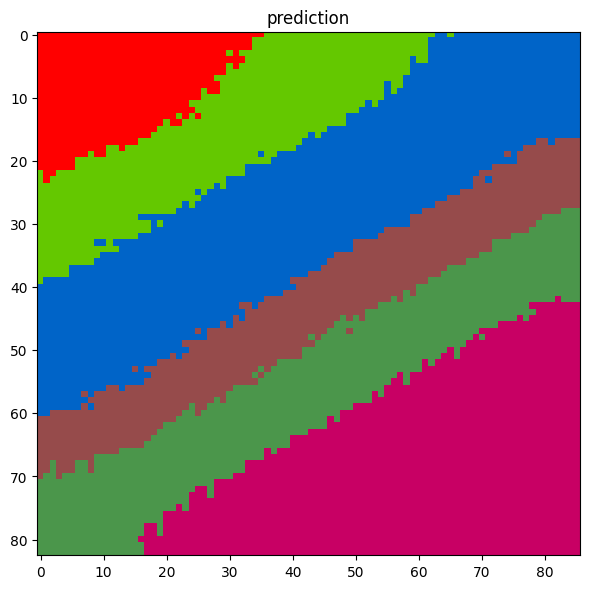

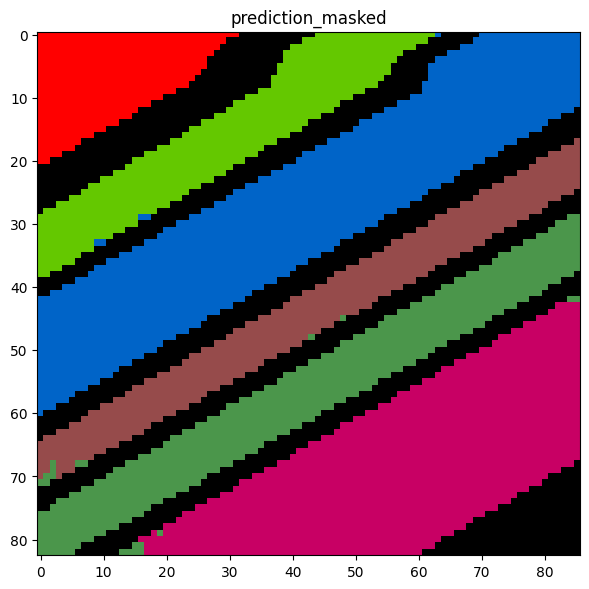

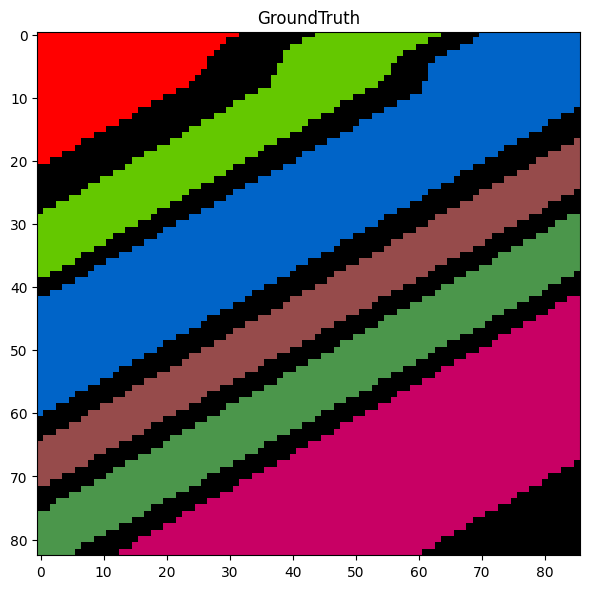

In [ ]:
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(labels!=0),title='prediction_masked',figsize=(7,7))
spectral.imshow(classes=labels, title='GroundTruth', figsize=(7, 7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(labels!=0),colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"Groundtruth.jpg"),labels, colors=spectral.spy_colors)

## Evaluation

In [ ]:
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4, zero_division=0)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9938350886206011
AA: 0.9932101356425703
Kappa: 0.9922824425154222
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1     1.0000    1.0000    1.0000       285
Corn_senesced_green_weeds     1.0000    0.9908    0.9954       977
      Lettuce_romaine_4wk     1.0000    0.9888    0.9944       448
      Lettuce_romaine_5wk     0.9955    1.0000    0.9978      1110
      Lettuce_romaine_6wk     1.0000    0.9796    0.9897       491
      Lettuce_romaine_7wk     0.9684    1.0000    0.9839       582

                 accuracy                         0.9938      3893
                macro avg     0.9940    0.9932    0.9935      3893
             weighted avg     0.9940    0.9938    0.9939      3893



### Confusion Matrix

In [ ]:
unique_classes = np.unique(test_true)
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
test_true_remapped = np.array([class_mapping[val] for val in test_true])
test_pred_remapped = np.array([class_mapping[val] for val in test_pred])


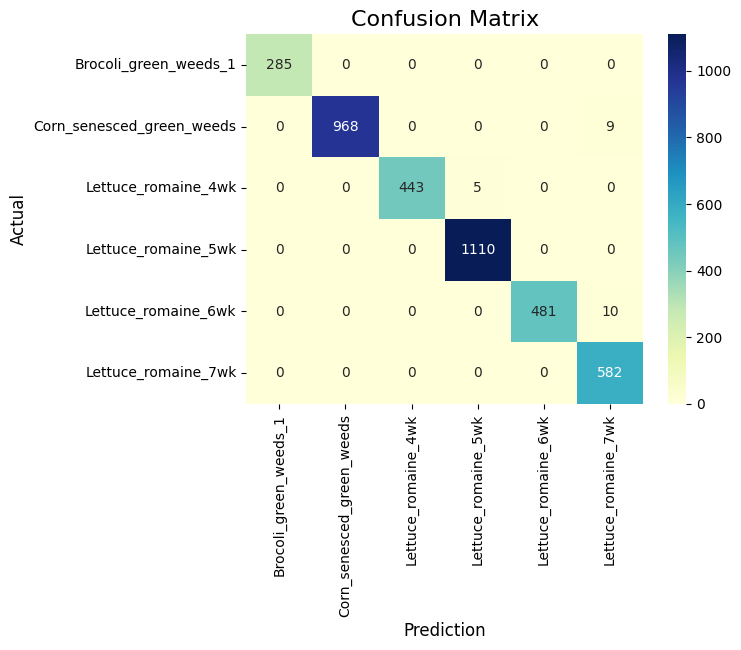

<Figure size 1000x1000 with 0 Axes>

Training completed in 30.17 seconds.
Completed in 34.19 seconds.


In [ ]:
cm = confusion_matrix(test_true_remapped, test_pred_remapped)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.figure(figsize=(10, 10))
plt.show()
#plt.savefig(os.path.join(SAVE_PATH, 'confusion_matrix_with_values.png'))


total_time = time.time() - start_time
print(f"Training completed in {total_training_time:.2f} seconds.")
print(f"Completed in {total_time:.2f} seconds.")